### Collecting weather historical data from Boston
#### Source: Weather API

Libraries

In [1]:
import datetime as dt
from dateutil.relativedelta import relativedelta
import urllib.request as req
import json
import time
import pandas as pd
from pytz import timezone
import matplotlib.pyplot as plt

Collecting for all months

In [2]:
def for_each_month(fn):
    start_date = dt.datetime(2018, 4, 1)
    end_of_all = dt.datetime(2019, 4, 1)
    while start_date < end_of_all:
        next_month = start_date + relativedelta(months=1)
        end_date = next_month - relativedelta(days=1)
        fn(start_date, end_date)
        start_date = next_month
        
@for_each_month
def print_interval(start_date, end_date):
    print(start_date, 'to', end_date)

2018-04-01 00:00:00 to 2018-04-30 00:00:00
2018-05-01 00:00:00 to 2018-05-31 00:00:00
2018-06-01 00:00:00 to 2018-06-30 00:00:00
2018-07-01 00:00:00 to 2018-07-31 00:00:00
2018-08-01 00:00:00 to 2018-08-31 00:00:00
2018-09-01 00:00:00 to 2018-09-30 00:00:00
2018-10-01 00:00:00 to 2018-10-31 00:00:00
2018-11-01 00:00:00 to 2018-11-30 00:00:00
2018-12-01 00:00:00 to 2018-12-31 00:00:00
2019-01-01 00:00:00 to 2019-01-31 00:00:00
2019-02-01 00:00:00 to 2019-02-28 00:00:00
2019-03-01 00:00:00 to 2019-03-31 00:00:00


In [ ]:
@for_each_month
def collect(start_date, end_date):
    url = 'https://api.weather.com/v1/geocode/42.36416626/-71.00499725/observations/historical.json' + \
          '?apiKey=6532d6454b8aa370768e63d6ba5a832e' + \
          '&startDate=' + start_date.strftime("%Y%m%d") + \
          '&endDate=' + end_date.strftime("%Y%m%d") + \
          '&units=m'
    print(url)
    response = req.urlopen(url)
    with open('../../data/boston/training-sets/weather/weather-' + start_date.strftime("%Y%m") +  '.json', 'w') as f:
        for line in response:
            f.write(line.decode())
    time.sleep(0.5)

Testing a collected file

In [ ]:
with open('../../data/boston/training-sets/weather/weather-201903.json') as f:
    text = f.read()

data = json.loads(text)
df = pd.DataFrame(data['observations'])
print(len(df), 'observations')
df.head()

Loading all data into a dataframe

In [3]:
df_list = []

@for_each_month
def mount_df(start_date, _):
    print(start_date)
    fname = '../../data/boston/training-sets/weather/weather-' + start_date.strftime("%Y%m") + '.json'
    with open(fname) as f:
        text = f.read()
    data = json.loads(text)
    df_list.append(pd.DataFrame(data['observations']))
    
weather_raw = pd.concat(df_list).reset_index(drop=True)
print(len(weather_raw), 'observations')
weather_raw.head()

2018-04-01 00:00:00
2018-05-01 00:00:00
2018-06-01 00:00:00
2018-07-01 00:00:00
2018-08-01 00:00:00
2018-09-01 00:00:00
2018-10-01 00:00:00
2018-11-01 00:00:00
2018-12-01 00:00:00
2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
10490 observations


blunt_phrase        class clds day_ind  dewPt  expire_time_gmt  feels_like  \
0         None  observation  OVC       N   -2.0       1522565640         1.0   
1         None  observation  OVC       N   -2.0       1522569240         1.0   
2         None  observation  OVC       N   -2.0       1522572840         2.0   
3         None  observation  OVC       N   -2.0       1522576440         2.0   
4         None  observation  OVC       N   -2.0       1522580040         2.0   

   gust  heat_index  icon_extd  ... uv_index  valid_time_gmt   vis water_temp  \
0   NaN         5.0       2600  ...        0      1522558440  16.0       None   
1   NaN         5.0       2600  ...        0      1522562040  16.0       None   
2   NaN         6.0       2600  ...        0      1522565640  16.0       None   
3  44.0         6.0       2600  ...        0      1522569240  16.0       None   
4  44.0         7.0       2690  ...        0      1522572840  16.0       None   

    wc   wdir  wdir_cardinal  wspd wx_icon       wx_phrase  
0  1.0  200.0            SSW  24.0      26          Cloudy  
1  1.0  200.0            SSW  22.0      26          Cloudy  
2  2.0  200.0            SSW  20.0      26          Cloudy  
3  2.0  210.0            SSW  26.0      26          Cloudy  
4  2.0  210.0            SSW  35.0      26  Cloudy / Windy  

[5 rows x 45 columns]

Boston times

In [4]:
def convert(gmt_time):
    gmt_time = dt.datetime.utcfromtimestamp(gmt_time)
    gmt_time = timezone('UTC').localize(gmt_time)
    boston_time = gmt_time.astimezone(timezone('US/Eastern'))
    return boston_time.replace(tzinfo=None)

weather_raw['valid_time_boston'] = weather_raw['valid_time_gmt'].apply(convert)
print('Min date:', weather_raw['valid_time_boston'].min())
print('Max date:', weather_raw['valid_time_boston'].max())
weather_raw['valid_time_boston'].head(10)

Min date: 2018-04-01 00:54:00
Max date: 2019-03-31 23:54:00


0   2018-04-01 00:54:00
1   2018-04-01 01:54:00
2   2018-04-01 02:54:00
3   2018-04-01 03:54:00
4   2018-04-01 04:54:00
5   2018-04-01 05:54:00
6   2018-04-01 06:54:00
7   2018-04-01 07:54:00
8   2018-04-01 08:54:00
9   2018-04-01 09:54:00
Name: valid_time_boston, dtype: datetime64[ns]

In [5]:
weather_raw.columns

Index(['blunt_phrase', 'class', 'clds', 'day_ind', 'dewPt', 'expire_time_gmt',
       'feels_like', 'gust', 'heat_index', 'icon_extd', 'key', 'max_temp',
       'min_temp', 'obs_id', 'obs_name', 'precip_hrly', 'precip_total',
       'pressure', 'pressure_desc', 'pressure_tend', 'primary_swell_direction',
       'primary_swell_height', 'primary_swell_period', 'primary_wave_height',
       'primary_wave_period', 'qualifier', 'qualifier_svrty', 'rh',
       'secondary_swell_direction', 'secondary_swell_height',
       'secondary_swell_period', 'snow_hrly', 'temp', 'terse_phrase',
       'uv_desc', 'uv_index', 'valid_time_gmt', 'vis', 'water_temp', 'wc',
       'wdir', 'wdir_cardinal', 'wspd', 'wx_icon', 'wx_phrase',
       'valid_time_boston'],
      dtype='object')

According to available in hourly forecast (for new predictions)
* Selecting the most indicative numeric variables

In [10]:
consider_only = [
    'dewPt', 'feels_like', 'heat_index', 'precip_hrly',
    'rh', 'temp', 'vis', 'wc', 'wspd'
]

In [11]:
for i in consider_only:
    print('---', i)
    print(weather_raw[i].value_counts().head(5))
    print()

--- dewPt
19.0    460
11.0    418
21.0    413
9.0     397
13.0    386
Name: dewPt, dtype: int64

--- feels_like
 21.0    479
 22.0    411
-1.0     382
-2.0     379
 1.0     359
Name: feels_like, dtype: int64

--- heat_index
3.0     483
4.0     482
21.0    479
2.0     460
1.0     427
Name: heat_index, dtype: int64

--- precip_hrly
0.00    9066
0.25     392
0.51     210
0.76     138
1.02     119
Name: precip_hrly, dtype: int64

--- rh
93.0    718
89.0    467
90.0    432
87.0    371
86.0    270
Name: rh, dtype: int64

--- temp
3.0     483
4.0     482
21.0    479
2.0     460
1.0     427
Name: temp, dtype: int64

--- vis
16.0    7695
4.0      478
2.0      347
3.0      295
1.0      253
Name: vis, dtype: int64

--- wc
 21.0    479
 22.0    411
-1.0     382
-2.0     379
 1.0     359
Name: wc, dtype: int64

--- wspd
17.0    948
15.0    933
19.0    926
13.0    925
11.0    884
Name: wspd, dtype: int64



Null values

In [12]:
for i in consider_only:
    print('---', i)
    print(weather_raw[i].isnull().value_counts())
    print()

--- dewPt
False    10487
True         3
Name: dewPt, dtype: int64

--- feels_like
False    10488
True         2
Name: feels_like, dtype: int64

--- heat_index
False    10487
True         3
Name: heat_index, dtype: int64

--- precip_hrly
False    10490
Name: precip_hrly, dtype: int64

--- rh
False    10487
True         3
Name: rh, dtype: int64

--- temp
False    10489
True         1
Name: temp, dtype: int64

--- vis
False    10489
True         1
Name: vis, dtype: int64

--- wc
False    10486
True         4
Name: wc, dtype: int64

--- wspd
False    10487
True         3
Name: wspd, dtype: int64



Evolution

--- dewPt
Min: -26.0
Max: 25.0


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


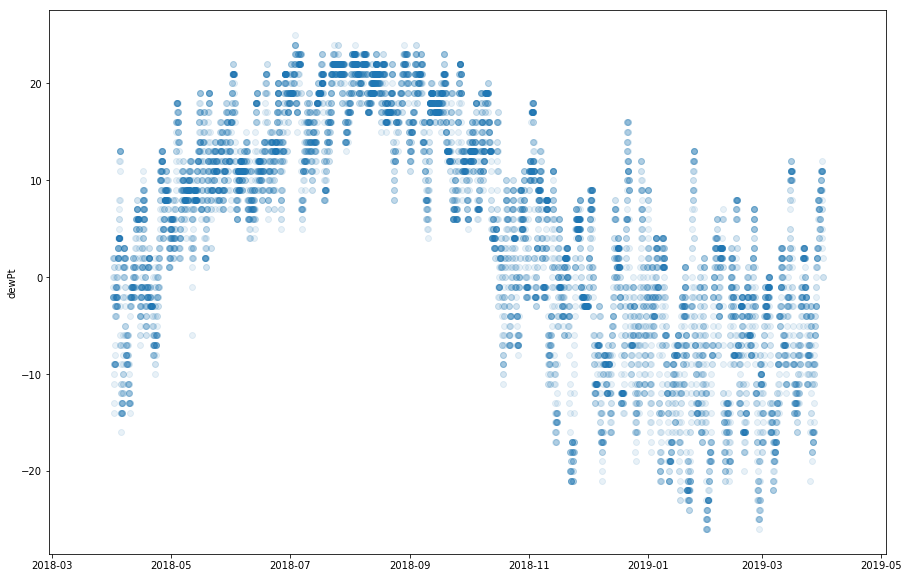

--- feels_like
Min: -27.0
Max: 41.0


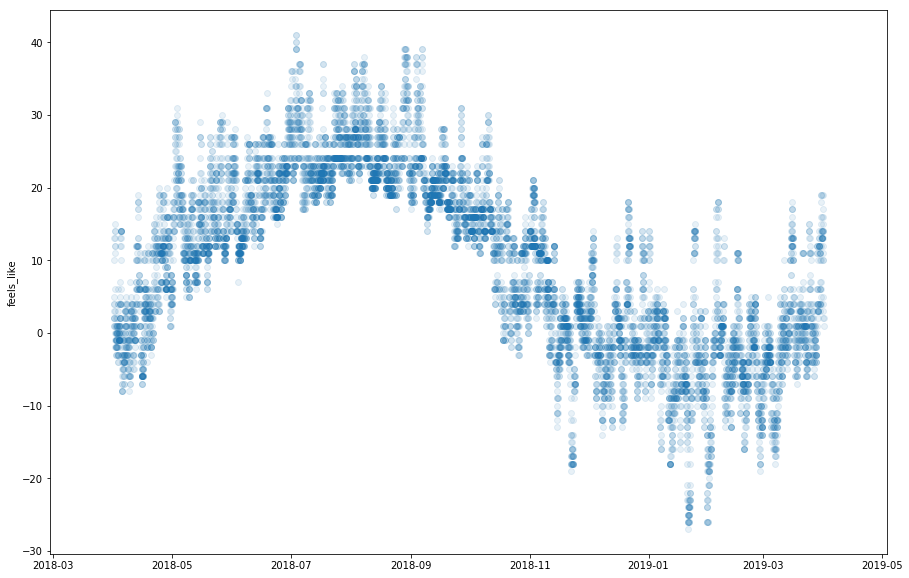

--- heat_index
Min: -15.0
Max: 41.0


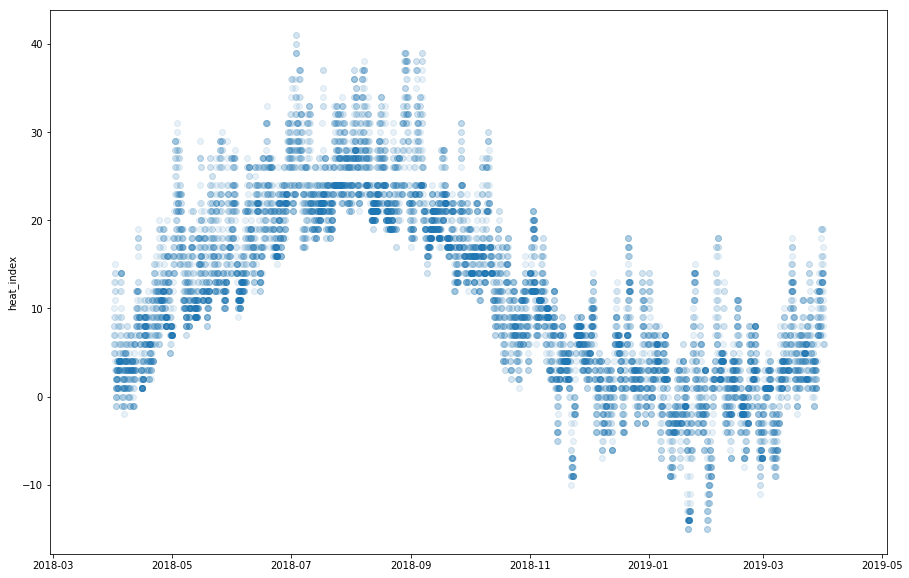

--- precip_hrly
Min: 0.0
Max: 27.94


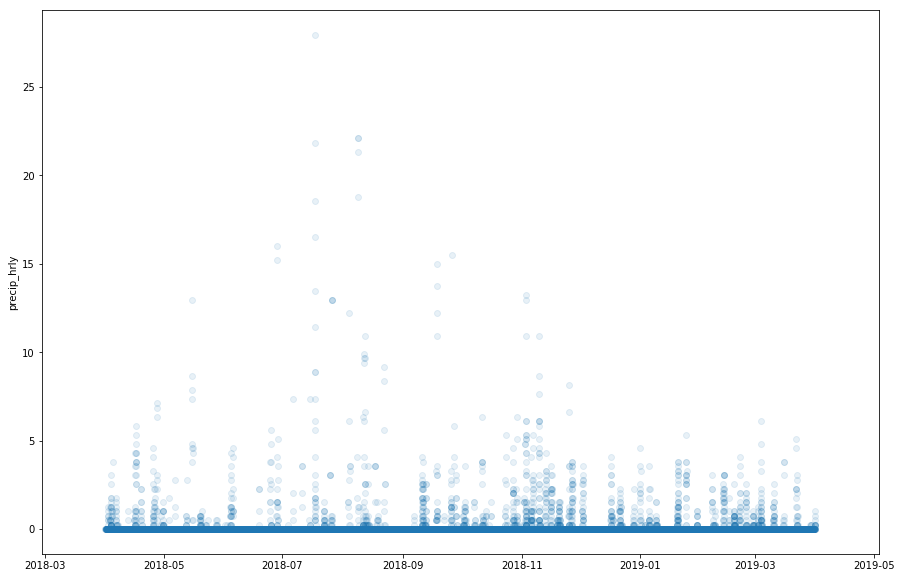

--- rh
Min: 10.0
Max: 100.0


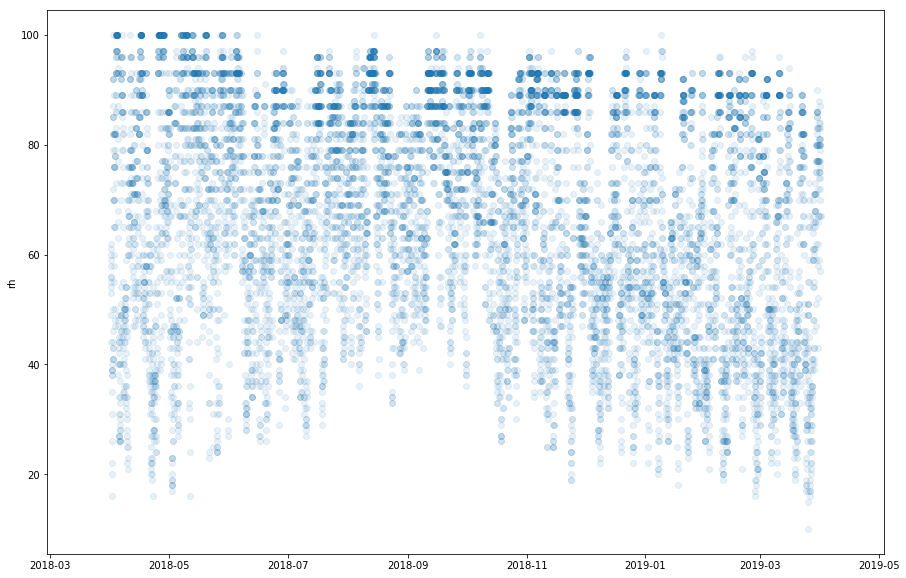

--- temp
Min: -15.0
Max: 36.0


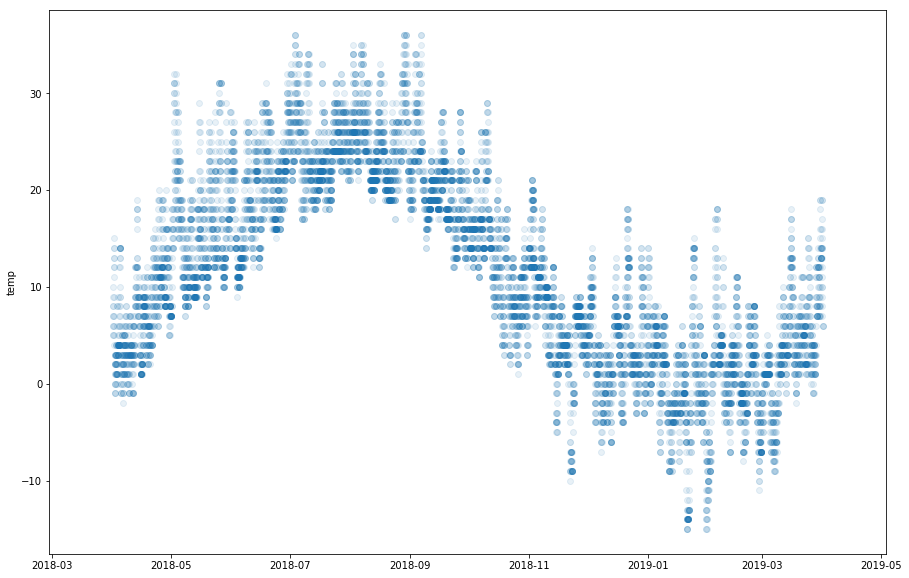

--- vis
Min: 0.0
Max: 16.0


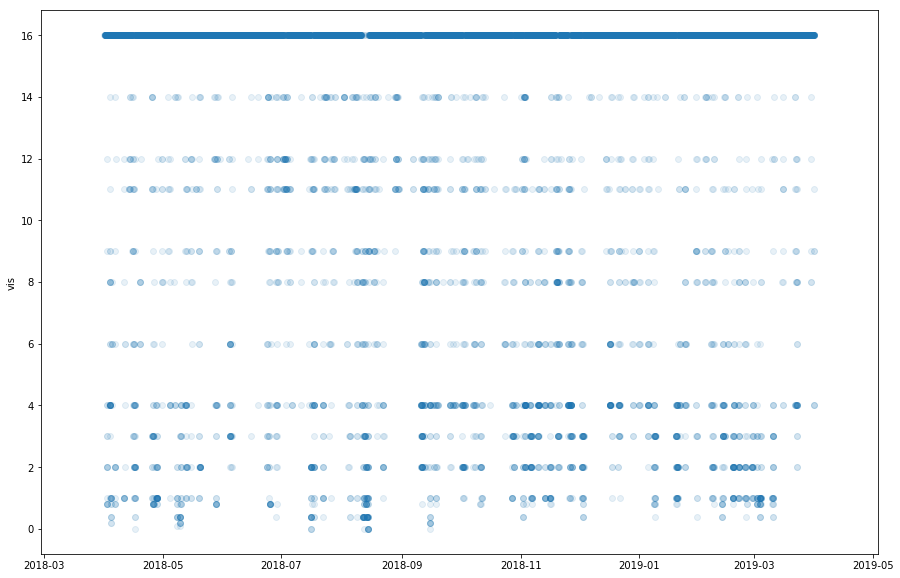

--- wc
Min: -27.0
Max: 36.0


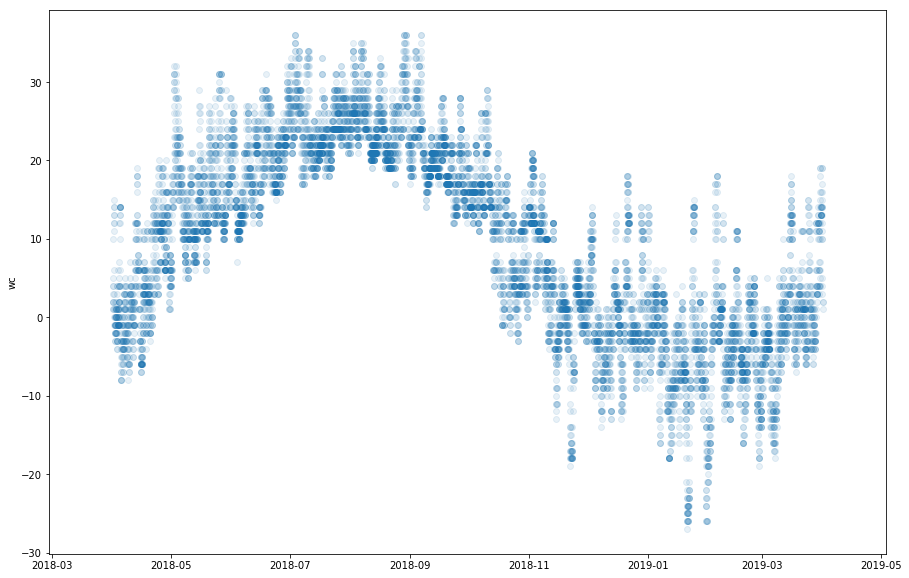

--- wspd
Min: 0.0
Max: 59.0


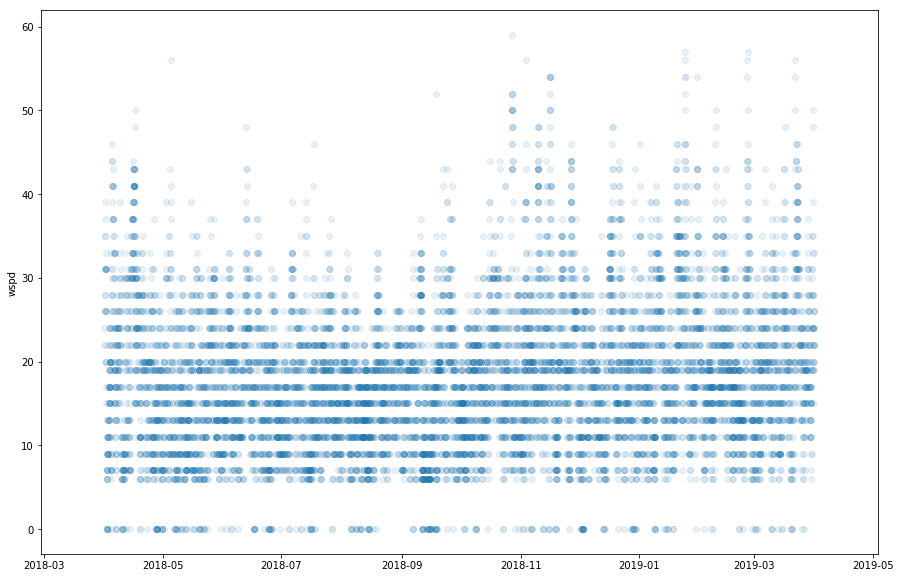

In [17]:
for c in consider_only:
    print('---', c)
    print('Min:', weather_raw[c].min())
    print('Max:', weather_raw[c].max())
    plt.figure(figsize=(15, 10))
    plt.ylabel(c)
    plt.scatter('valid_time_boston', c, data=weather_raw, alpha=0.1)
    plt.show()

Saving with raw data for testing :)
* No interpolating for now

In [46]:
weather_raw.rename(columns={'dewPt': 'dew_pt', 'valid_time_boston': 'time'}, inplace=True)
consider_only = [
    'time', 'dew_pt', 'feels_like', 'heat_index', 'precip_hrly',
    'rh', 'temp', 'vis', 'wc', 'wspd'
]
weather_raw[consider_only].to_csv('../../data/boston/training-sets/processing/weather.csv', index=False)